### LASSO parameter range experiments: microsatellite instability (MSI) prediction

This script is similar to `02_classify_cancer_type/lasso_range_gene.ipynb`, but for MSI prediction across cancer types. MSI information is only included for SKCM (stomach cancer), COAD/READ (colorectal cancer), and UCEC (uterine endometrical carcinoma).

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '10_msi_prediction', 'results', 'msi_lasso_range_sex_covariate_lr'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

metric = 'aupr'
nz_cutoff = 5.0

output_plots = False
output_plots_dir = None

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range_msi(results_dir):
    (cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)
nz_coefs_df.head()

,cancer_type,lasso_param,seed,fold,nz_coefs
0,UCEC,0.001,42,0,0
1,UCEC,0.001,42,1,0
2,UCEC,0.001,42,2,0
3,UCEC,0.001,42,3,0
4,UCEC,1500.000,1,0,8392


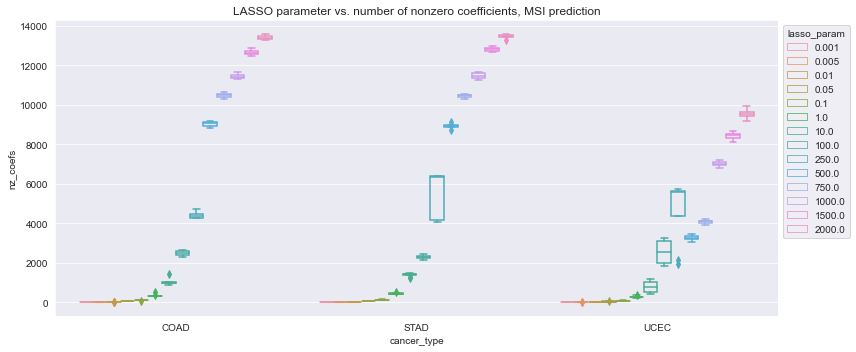

In [4]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param'
)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
ax = plt.gca()
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers

# also fix the legend to color the edges rather than fill
for legpatch in ax.legend_.get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f'LASSO parameter vs. number of nonzero coefficients, MSI prediction')
plt.tight_layout()

### Get performance information for each lasso penalty

In [5]:
perf_df = au.load_prediction_results_lasso_range_msi(results_dir, training_dataset)
perf_df.drop(columns=['gene'], inplace=True)
perf_df.lasso_param = perf_df.lasso_param.astype(float)

perf_df.head()

,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.00000,UCEC,signal,1,train,0,all_other_cancers,1.0
1,0.92253,0.92050,UCEC,signal,1,test,0,all_other_cancers,1.0
2,0.99200,0.97862,UCEC,signal,1,cv,0,all_other_cancers,1.0
3,1.00000,1.00000,UCEC,signal,1,train,1,all_other_cancers,1.0
4,0.97143,0.95249,UCEC,signal,1,test,1,all_other_cancers,1.0


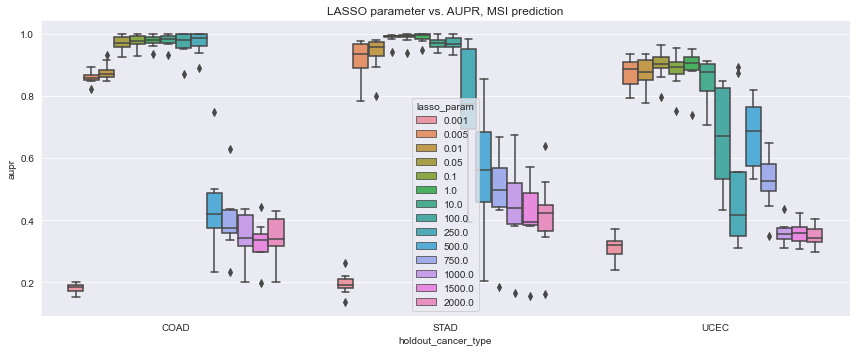

In [6]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=(
        perf_df[(perf_df.signal == 'signal') &
                (perf_df.data_type == 'test')]
          .sort_values(by=['holdout_cancer_type', 'lasso_param'])
    ), x='holdout_cancer_type', y=metric, hue='lasso_param'
)
plt.title(f'LASSO parameter vs. {metric.upper()}, MSI prediction')
plt.tight_layout()

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(output_plots_dir / f'msi_lasso_boxes.png',
                dpi=200, bbox_inches='tight')

/home/jake/miniconda3/envs/pc-eval/lib/python3.8/site-packages/seaborn/axisgrid.py:38: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(**kwargs)


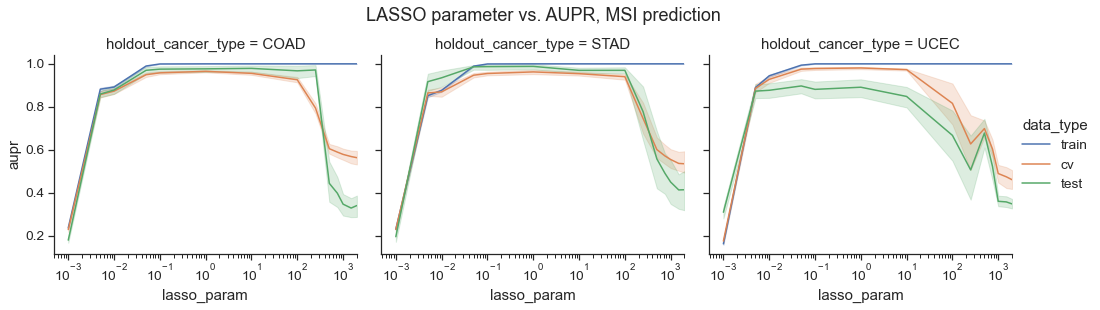

In [7]:
# try with a float-valued x-axis
# this is probably more "correct" than treating each lasso parameter as a
# category (above plot); here the spaces between parameters reflect their
# actual real-valued distance in log-space
sns.set({'figure.figsize': (12, 5)})
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)

with sns.plotting_context('notebook', font_scale=1.25):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        kind='line', col='holdout_cancer_type',
        col_wrap=3, height=4, aspect=1.2
    )
    g.set(xscale='log', xlim=(0, max(plot_df.lasso_param)))
    plt.suptitle(f'LASSO parameter vs. {metric.upper()}, MSI prediction', y=1.05)

if output_plots:
    plt.savefig(output_plots_dir / f'msi_lasso_facets.png',
                dpi=200, bbox_inches='tight')

In [8]:
plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .merge(nz_coefs_df, left_on=['holdout_cancer_type', 'lasso_param', 'seed', 'fold'],
             right_on=['cancer_type', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['cancer_type'])
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)
plot_df.head()

,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param,nz_coefs
0,0.5,0.23994,COAD,signal,1,train,0,all_other_cancers,0.001,0
1,0.5,0.17647,COAD,signal,1,test,0,all_other_cancers,0.001,0
2,0.5,0.22321,COAD,signal,1,cv,0,all_other_cancers,0.001,0
3,0.5,0.23696,COAD,signal,1,train,1,all_other_cancers,0.001,0
4,0.5,0.20000,COAD,signal,1,test,1,all_other_cancers,0.001,0


0.100 1.000000
0.200 5.000000
0.300 84.200000
0.400 394.000000
0.500 1676.000000
0.600 3459.000000
0.700 7004.300000
0.800 9573.000000
0.900 11666.000000


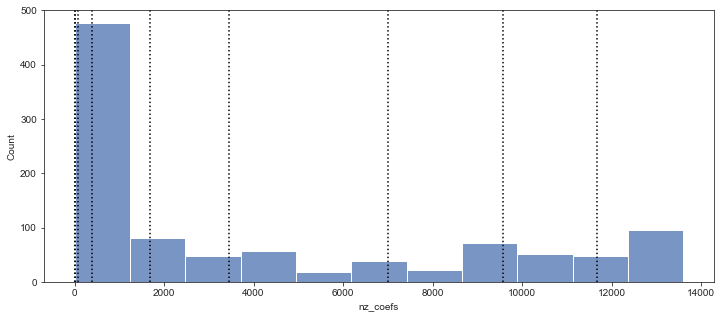

In [9]:
sns.histplot(plot_df.nz_coefs)
for q in np.linspace(0.1, 0.9, 9):
    print(f'{q:.3f}', f'{plot_df.nz_coefs.quantile(q):3f}')
    plt.gca().axvline(x=plot_df.nz_coefs.quantile(q), color='black', linestyle=':')

In [10]:
plot_df['nz_quantile'] = pd.qcut(
    plot_df.nz_coefs,
    q=np.linspace(0, 1, 11),
    labels=[f'{q}' for q in range(1, 11)]
)

print(plot_df.nz_quantile.unique())
plot_df.head()

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Categories (10, object): ['1' < '2' < '3' < '4' ... '7' < '8' < '9' < '10']


,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param,nz_coefs,nz_quantile
0,0.5,0.23994,COAD,signal,1,train,0,all_other_cancers,0.001,0,1
1,0.5,0.17647,COAD,signal,1,test,0,all_other_cancers,0.001,0,1
2,0.5,0.22321,COAD,signal,1,cv,0,all_other_cancers,0.001,0,1
3,0.5,0.23696,COAD,signal,1,train,1,all_other_cancers,0.001,0,1
4,0.5,0.20000,COAD,signal,1,test,1,all_other_cancers,0.001,0,1


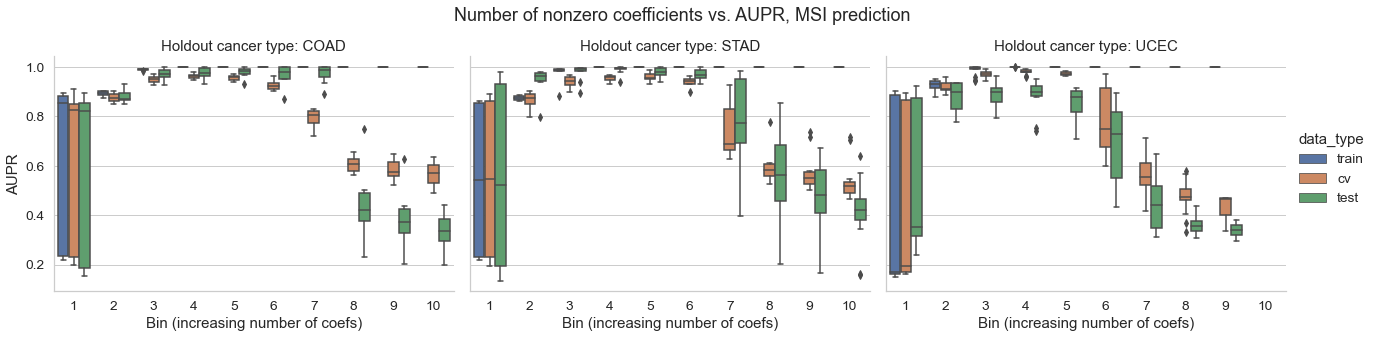

In [11]:
# try with a float-valued x-axis
# this is probably more "correct" than treating each lasso parameter as a
# category (above plot); here the spaces between parameters reflect their
# actual real-valued distance in log-space
# sns.set({'figure.figsize': (25, 7)})
sns.set_style('whitegrid')

with sns.plotting_context('notebook', font_scale=1.25):
    g = sns.catplot(
        data=plot_df,
        x='nz_quantile', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        kind='box', col='holdout_cancer_type',
        col_wrap=3, height=4.5, aspect=1.35
    )
    g.set_titles('Holdout cancer type: {col_name}')
    g.set_xlabels('Bin (increasing number of coefs)')
    g.set_ylabels(f'{metric.upper()}')
    plt.suptitle(f'Number of nonzero coefficients vs. {metric.upper()}, MSI prediction', y=1.05)

if output_plots:
    plt.savefig(output_plots_dir / f'msi_lasso_facets.png',
                dpi=200, bbox_inches='tight')

Observations:

* Intermediate lasso penalties seem to perform the best for all 3 included cancer types, on both the validation data and the data from the held-out cancer type. These models typically have several hundred features with nonzero weights.
* Generalizing to UCEC from the other cancer types seems to be the hardest. This isn't too surprising since it only occurs in women, which likely makes it more different from the other carcinomas than they are from each other. This is true whether or not a sex covariate is included in the model.